In [5]:
from os import scandir
from os.path import join
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd

from src.utils.utils import plot_disease_distribution

In [2]:
train_data_df_path = "../datasets/csv_splits/COVID-19_Radiography_Dataset_train.csv"
val_data_df_path = "../datasets/csv_splits/COVID-19_Radiography_Dataset_val.csv"

train_data_df = pd.read_csv(train_data_df_path)
val_data_df = pd.read_csv(val_data_df_path)

In [3]:
train_data_df.head()

,Image Index,Finding Labels,Path,COVID,Lung_Opacity,Normal,Viral Pneumonia
0,COVID-1.png,COVID,train/COVID,1,0,0,0
1,COVID-1000.png,COVID,train/COVID,1,0,0,0
2,COVID-1001.png,COVID,train/COVID,1,0,0,0
3,COVID-1002.png,COVID,train/COVID,1,0,0,0
4,COVID-1004.png,COVID,train/COVID,1,0,0,0


In [6]:
def get_split(n_splits: int, len_elements: int, unbalanced: bool) -> np.ndarray:
    """Get the split sizes for the clients.

    Args:
    -----
        n_splits (int): Number of clients to split the data into.
        len_elements (int): Number of elements to split.
        unbalanced (bool): Whether to split the data into unbalanced clients.

    Returns:
    --------
        np.ndarray: Array containing the split sizes.
    """
    if unbalanced:
        random_points = np.sort(
            np.random.choice(range(1, len_elements), n_splits - 1, replace=False)
        )
        split_sizes = np.diff([0] + random_points.tolist() + [len_elements])
    else:
        base_size = len_elements // n_splits
        split_sizes = np.array([base_size] * n_splits)
        remainder = len_elements % n_splits
        if remainder > 0:
            indices = np.random.choice(range(n_splits), size=remainder, replace=False)
            split_sizes[indices] += 1

    return split_sizes


def split_targets(reamaining_clients: list, removed_images: dict, df: pd.DataFrame) -> dict:
    """Split the removed images into the remaining clients.

    Args:
    -----
        reamaining_clients (list): List of clients to assign the removed images to.
        removed_images (dict): Dictionary containing the removed images for each client.

    Returns:
    --------
        dict: Dictionary containing the split images for each client.
    """
    splits = {idx: {} for idx in removed_images.keys()}
    for idx, imgs in removed_images.items():
        # for client in reamaining_clients:
        #     if imgs.size > 0:
        classes = df[df["Image Index"].isin(imgs)]["Finding Labels"].str.split("|").explode().unique()
        # Split classes into n remaining clients
        for cls in classes:
            filtered = df[df["Image Index"].isin(imgs)]
            filtered = filtered[filtered["Finding Labels"].str.contains(cls)]
            split_sizes = get_split(len(reamaining_clients), len(filtered), False)
            split_clients = np.split(filtered["Image Index"].values, np.cumsum(split_sizes)[:-1])
            for i, client in enumerate(reamaining_clients):
                # splits[client].extend(split_clients[i])
                splits[idx][client] = split_clients[i]
                
    return splits


def random_fl_split(
    n_splits: int,
    df: pd.DataFrame,
    unbalanced: bool = False,
    extreme: bool = False,
    # target_clients: Union[List[int], int] = None,
    # target_classes: Union[List[str], str] = None,
    target_classes: Dict[int, List[str]] = None,
    seed: int = 42,
) -> Tuple[pd.DataFrame]:
    """
    Splits the dataset into `n_splits` clients using random assignment with optional unbalancing.

    Args:
        n_splits (int): Number of clients to split the data into.
        df (pd.DataFrame): DataFrame containing the data with "Image Index" and "Finding Labels".
        unbalanced (bool): If True, creates unbalanced splits.
        extreme (bool): If True, applies extreme unbalancing based on `target_clients` and `target_classes`.
        target_classes (Dict[int, List[str]]): Dictionary containing the target classes to be removed from each client.
        seed (int): Seed for reproducibility.

    Returns:
        Tuple[pd.DataFrame]: Tuple containing the DataFrames for each client.
    """
    np.random.seed(seed)

    images = df["Image Index"].unique()
    np.random.shuffle(images)

    assert 0 < n_splits <= len(images), "n_splits must be between 1 and the number of unique images."
    assert len(target_classes) < len(df["Finding Labels"].unique()), "Number of target classes must be less than the available number of classes."
    
    # if isinstance(target_clients, int):
    #     target_clients = [target_clients]
    if isinstance(target_classes, str):
        target_classes = [target_classes]

    # Generate split sizes
    # if unbalanced:
    #     random_points = np.sort(np.random.choice(len(images) - 1, n_splits - 1, replace=False))
    #     split_sizes = np.diff([0] + random_points.tolist() + [len(images)])
    # else:
    #     split_sizes = np.full(n_splits, len(images) // n_splits)
    #     split_sizes[:len(images) % n_splits] += 1
    split_sizes = get_split(n_splits, len(images), unbalanced)

    clients = np.split(images, np.cumsum(split_sizes)[:-1])

    if extreme and target_classes:
        target_clients = list(target_classes.keys())
        to_swap = {idx: [] for idx in target_clients}
        for idx in target_clients:
            filtered = df[df["Image Index"].isin(clients[idx])]
            filtered = filtered[filtered["Finding Labels"].str.contains("|".join(target_classes[idx]))]
            to_swap[idx] = filtered["Image Index"].values

        remaining_clients = [client for client in range(n_splits) if client not in target_clients]

        removed_images = split_targets(remaining_clients, to_swap, df)

        for idx, splits in removed_images.items():
            for client, split in splits.items():
                clients[client] = np.concatenate([clients[client], split])
                clients[idx] = np.setdiff1d(clients[idx], split)

    client_dfs = [df[df["Image Index"].isin(client)].reset_index(drop=True) for client in clients]

    return tuple(client_dfs)

In [ ]:
# client_dfs = random_fl_split(4, train_data_df, unbalanced=True, extreme=True, target_clients=[1, 2], target_classes=["COVID"], seed=1651)

n_clients = 2

target_classes = {
    1: ["COVID", "Lung_Opacity"],
    2: ["Normal"]
}

client_dfs = random_fl_split(n_clients, val_data_df, unbalanced=False, extreme=False, target_classes=target_classes, seed=1651)
# remaining_clients, to_swap = random_fl_split(4, train_data_df, unbalanced=True, extreme=True, target_classes=target_classes, seed=1651)

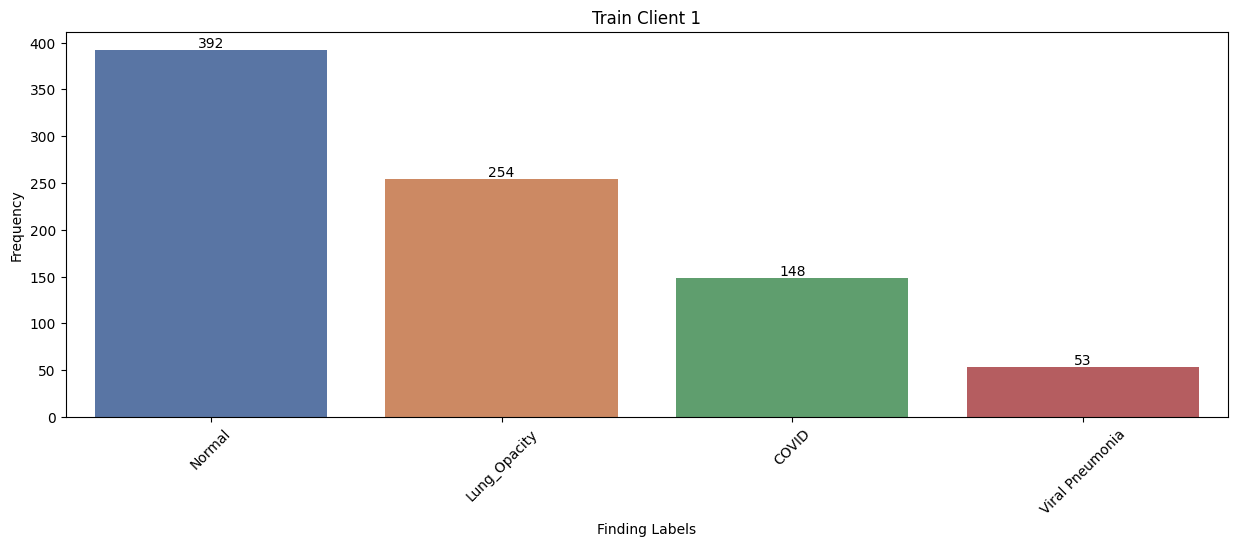

In [273]:
plot_disease_distribution(client_dfs[0], "Train Client 1")

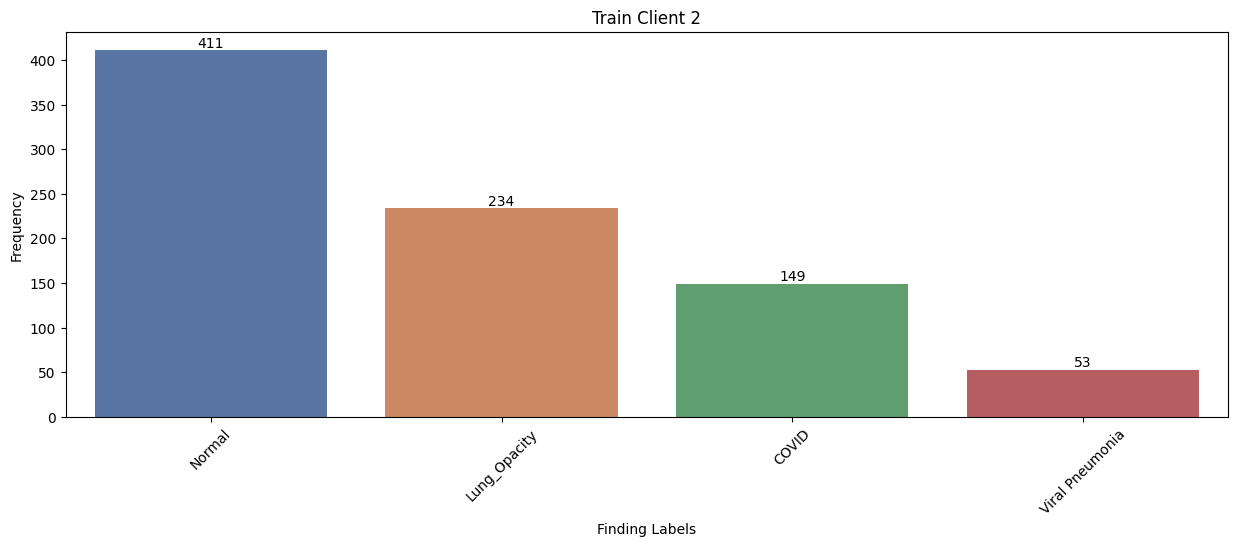

In [274]:
plot_disease_distribution(client_dfs[1], "Train Client 2")

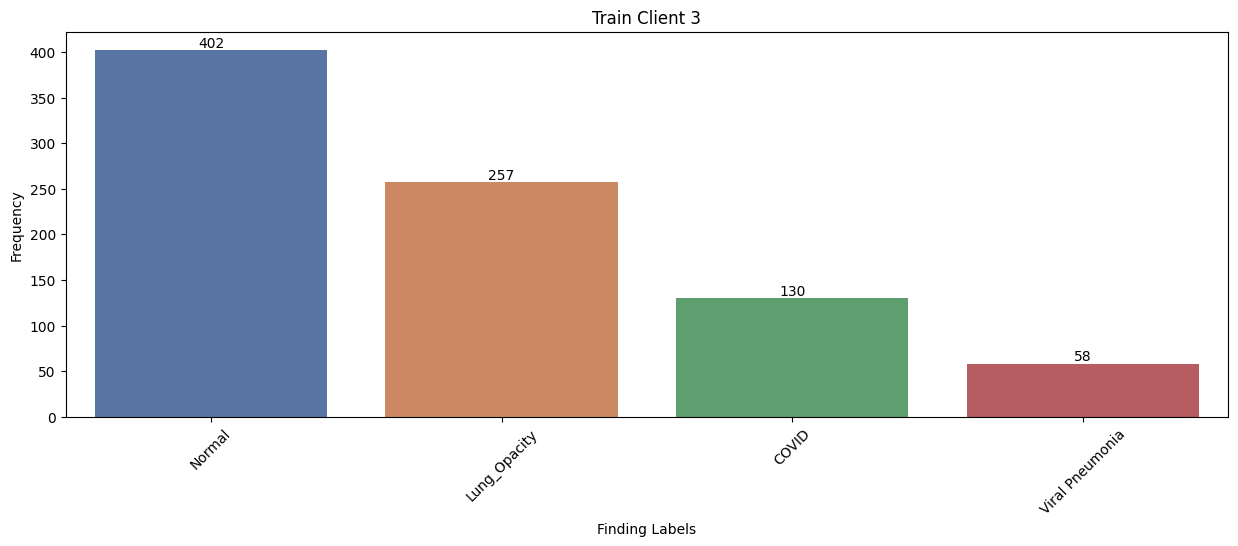

In [275]:
plot_disease_distribution(client_dfs[2], "Train Client 3")

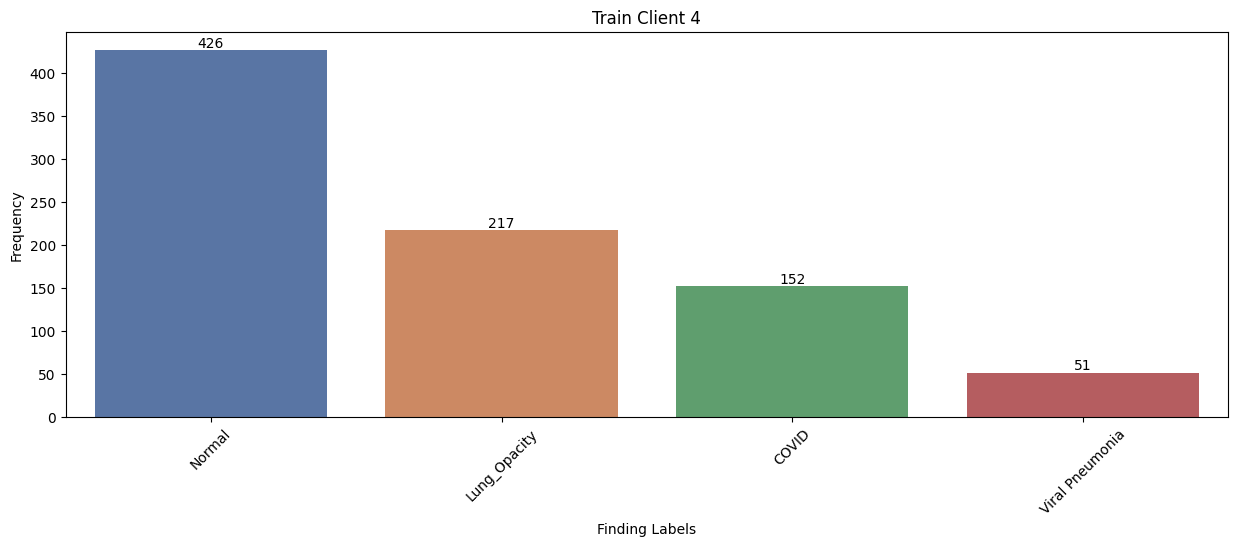

In [276]:
plot_disease_distribution(client_dfs[3], "Train Client 4")

In [270]:
# Intersecting images
len(set(client_dfs[0]["Image Index"].unique()).intersection(set(client_dfs[1]["Image Index"].unique())))

0

In [277]:
for idx, cl_df in enumerate(client_dfs):
    cl_df.to_csv(f"../datasets/csv_splits/{n_clients}_clients/unbalanced_missing_classes/CXR_covid_val_client_{idx + 1}.csv", index=False)